# Phase Space Analysis
Code to look at particle trajectories in the integrable phase space

## Setup

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.integrate
import scipy.interpolate

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyvista as pv

from tqdm import tqdm

## Utility libraries
from netCDF4 import Dataset

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [2]:
# %% Load data files

eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, **geom_files)

# Set up zonal interpolation function
tind = 401
zonalFields = XgcZonalFieldHandler(eq, xgcdata, 401)

# Load phase velocities
uph = np.load('./outputs/phase_vel.npz')['u_lstsq']
interp_uph = scipy.interpolate.CubicSpline(geom.psi_surf, uph[tind,:])

Text(0, 0.5, "$\\Omega_{ZF}'(\\psi) / q'(\\psi)$")

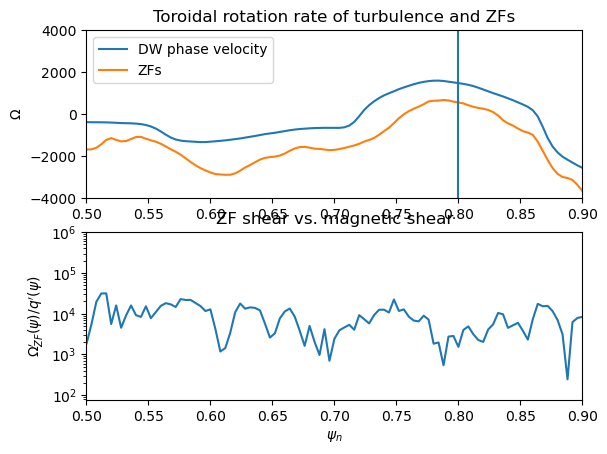

In [3]:
# %% Plot phase space velocities

plt.figure()

ax = plt.subplot(211)
plt.plot(geom.psi_surf / eq.psix, uph[tind,:] * geom.q_surf, label='DW phase velocity')
plt.plot(geom.psi_surf / eq.psix, -zonalFields.interp_phi(geom.psi_surf, nu=1), label='ZFs')
plt.axvline(geom.psi_surf[200] / eq.psix)
plt.ylabel(R'$\Omega$')
plt.title('Toroidal rotation rate of turbulence and ZFs')

plt.legend()

plt.xlim(0.5, 0.9)
plt.ylim(-4000,4000)

plt.subplot(212, sharex=ax)
plt.semilogy(geom.psi_surf / eq.psix, np.abs(zonalFields.interp_phi(geom.psi_surf, nu=2)) / np.abs(geom.interp_q(geom.psi_surf, nu=1)))
#plt.semilogy(geom.psi_surf / eq.psix, )
plt.title('ZF shear vs. magnetic shear')
plt.xlabel(R'$\psi_n$')
plt.ylabel(R"$\Omega_{ZF}'(\psi) / q'(\psi)$")


## Particle Pushing

In [16]:
# %% Set up particle properties

# Set up rotating frame
tind0 = 401
omega_frame = -uph[tind0,196]*geom.q_surf[196]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(0, omega_frame, tind0)
t0 = rotating_frame.t0

# Choose which particle properties to use
pp = particle_motion.deut

# Set initial position and parallel velocity
r0 = eq.interp_router(geom.psi_surf[196]/eq.psix)
z0 = geom.zaxis
x0 = np.array([r0, 0.0, z0])

# Compute magnetic field at initial position
bv = eq.compute_bv(x0[0], x0[2])
modb = np.linalg.norm(bv)
bu = bv / modb

## Compute the rotation frequency and the mean parallel velocity
psi0 = eq.interp_psi.ev(x0[0], x0[2])
omega0 = -zonalFields.interp_phi(psi0, nu=1)*zonalFields.scale_conversion()
vll_mean = eq.interp_ff(psi0) * omega0 / modb

## Determine the initial values of the integrals

# Particle kinetic energy in keV
ev0 = 0.75
# Set the initial pitch angle squared (cosine^2 of the angle between velocity and magnetic field)
xi0 = 0.67
# Set the initial parallel velocity
vll0 = vll_mean + pp.vt * np.sqrt(xi0) * np.sqrt(ev0)
# Initial magnetic moment
mu0 = pp.m * (np.sqrt(1-xi0)*pp.vt * np.sqrt(ev0))**2 / 2 / modb

# Compute initial integrals
ham0, lphi0 = particle_tools.compute_integrals_dk(t0, np.concatenate((x0, [vll0, mu0])), eq, pp, zonalFields, rotating_frame)


In [17]:
# %% Perform some particle pushing

pp = particle_motion.deut

#fields.set_phimult(1)

# Grid of radial points to check
#if pp.z > 0:
#    psin_grid = np.linspace(0.93, 1.02, 64)
#else:
#    psin_grid = np.linspace(0.95, 1.00, 4)

#psin_grid = np.array([0.8])
psin_grid = np.linspace(0.77, 0.83, 32, endpoint=False)
#psin_grid = np.array([0.81])
router_grid = eq.interp_router(psin_grid)
rinner_grid = eq.interp_rinner(psin_grid)


## Reference quantities for the `initial particle distribution'
# Which flux surface to put the reference particle on
#psin_ref = 0.9716
psin_ref = geom.psi_surf[196] / eq.psix
ff_ref = eq.interp_ff(psin_ref*eq.psix)

r_outer_ref = eq.interp_router(psin_ref)
bv_outer_ref = eq.compute_bv(eq.interp_router(psin_ref), 0)
modb_outer_ref = np.linalg.norm(bv_outer_ref)
bu_outer_ref = bv_outer_ref / modb_outer_ref

r_inner_ref = eq.interp_rinner(psin_ref)
bv_inner_ref = eq.compute_bv(eq.interp_rinner(psin_ref), 0)
modb_inner_ref = np.linalg.norm(bv_inner_ref)
bu_inner_ref = bv_inner_ref / modb_inner_ref

# Grid of reference particle kinetic energies in keV
kev_grid = np.array([0.75])

# Grid for mu; we do a hybrid between an equal spacing in pitch angle xi = cos(theta)
# and a factor which deals with the fact that at different poloidal angles, we have
# different distributions for mu.
# Pitch angle is defined as the angle between v and B.
xi_grid = np.linspace(-1, 1, 10)[1:-1]
pol_grid = np.linspace(0, np.pi, len(xi_grid)+2)[1:-1]
modb_pol_grid = modb_outer_ref * np.sin(pol_grid)**2 + modb_inner_ref * np.cos(pol_grid)**2
mu_grid = kev_grid[:,np.newaxis] * (1 - xi_grid[np.newaxis,:]**2) / modb_pol_grid[np.newaxis,:]

# Toroidal component of the angular momentum
bu_t_pol_grid = bu_outer_ref[1] * np.sin(pol_grid)**2 + bu_inner_ref[1] * np.cos(pol_grid)**2
r_pol_grid = r_outer_ref * np.sin(pol_grid)**2 + r_inner_ref * np.cos(pol_grid)**2

# Rotation velocity of reference Maxwellian. The idea is that we add the parallel velocity
# to the baseline particle energy
omega_rotation = -zonalFields.interp_phi(psin_ref*eq.psix, nu=1)*zonalFields.scale_conversion()

# Omega of the rotating mode; assume that perturbations are typically of the form
# exp(n*j*(omega_J * t - varphi)), i.e. rigidly toroidally rotating modes,
# which will then conserve the combination J = H + omega_J * P_\varphi.
# We assume that this J is then an adiabatic invariant of sorts.

## Array to hold the solutions
sol_array = np.empty((len(kev_grid), len(xi_grid), len(psin_grid)), dtype=object)

## The idea is that we want to scan different orbits for each fixed (Jref, mu).
# The inner loop gives the classes of orbits that can get collisionlessly scattered
# into/out of when a perturbation is added. In the current formulation, where
# kinetic energy is in the outer-most loop, the idea is that if pitch-angle scattering
# is the dominant collisional mechanism, then particles will remain in the same
# kinetic energy `shell'. 
for k_e in range(len(kev_grid)):
    for k_xi in range(len(xi_grid)):
        # Compute mean parallel velocity
        vll_mean = ff_ref * omega_rotation / modb_pol_grid[k_xi]

        # Compute parallel velocity from the pitch angle
        vll_pitch = np.sqrt(2 * kev_grid[k_e] / pp.m) * xi_grid[k_xi]

        # Reference velocity = pitch angle + mean components
        vll_ref = vll_mean + vll_pitch

        # Kinetic energy associated with perpendicular and parallel directions
        ke_mu = kev_grid[k_e] * (1 - xi_grid[k_xi]**2)
        ke_ll = pp.m * vll_ref**2 / 2

        # Baseline energy, chosen to be a thermal particle at the nontwist torus
        ham_ref = ke_ll + ke_mu + pp.z*zonalFields.interp_phi(psin_ref*eq.psix)*zonalFields.scale_conversion()

        # Baseline angular momentum
        lphi_ref = pp.z*psin_ref*eq.psix + pp.m*vll_ref*bu_t_pol_grid[k_xi]*r_pol_grid[k_xi]

        # Baseline magnetic moment
        mu_ref = mu_grid[k_e,k_xi]
        
        # The adiabatic invariant J associated with a rigid toroidally rotating mode
        adiabat_ref = ham_ref - lphi_ref * omega_frame
        
        
        print('K = {}; cos(xi) = {}; Jref = {}'.format(kev_grid[k_e], xi_grid[k_xi], adiabat_ref))
        
        for k_psin in tqdm(range(len(psin_grid))):
            # Via conservation of the adiabatic invariant Jref, we have that
            # J = H(R,pll) - omega_J * P_{\varphi}(R,pll) = Jref. Note that this is
            # a quadratic equation in pll = mi * vll. We specify R, then collect
            # the coefficients as c2 vll^2 + c1 vll^1 + c0 = 0 to solve for vll
            # in terms of (R,Jref).
            
            psin = psin_grid[k_psin]
            psi = psin*eq.psix
            
            # Alternate between taking the inner and outer flux surface
            if k_psin % 2 == 0:
                r = router_grid[k_psin]
            else:
                r = rinner_grid[k_psin]
            
            bv = eq.compute_bv(r, 0)
            modb = np.linalg.norm(bv)
            bu = bv / modb
            
            mu0 = mu_ref

            kll, pll_mean = particle_tools.compute_parallel_energy(t0, r, 0, 0, mu0, ham_ref, lphi_ref, eq, pp, zonalFields, rotating_frame)
            
            # Check if the term in the square root is positive, i.e. check for admissibility
            if (kll) < 0:
                continue
            else:
                x0 = np.array([r, 0, 0])
                vll0 = (pll_mean + np.sign(xi_grid[k_xi]) * np.sqrt(2 * pp.m * kll)) / pp.m
                
                z0 = np.concatenate((x0, [vll0, mu0]))
                
                dz0 = particle_motion.f_driftkinetic(0, z0, eq, pp, zonalFields)
                
                event_transit = particle_motion.event_copassing if dz0[2] > 0 else particle_motion.event_ctrpassing
                
                sol_array[k_e,k_xi,k_psin] = scipy.integrate.solve_ivp(particle_motion.f_driftkinetic,
                                                   [0, 300], z0,
                                                   atol=1e-8, rtol=1e-8,
                                                   args=(eq, pp, zonalFields),
                                                   events=[event_transit, particle_motion.event_botloss])


K = 0.75; cos(xi) = -0.7777777777777778; Jref = 0.4275060878033744


100%|██████████| 32/32 [00:05<00:00,  6.11it/s]


K = 0.75; cos(xi) = -0.5555555555555556; Jref = 0.4269247910481472


100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


K = 0.75; cos(xi) = -0.33333333333333337; Jref = 0.4254946935053037


100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


K = 0.75; cos(xi) = -0.11111111111111116; Jref = 0.4232199963617766


100%|██████████| 32/32 [00:05<00:00,  5.96it/s]


K = 0.75; cos(xi) = 0.11111111111111116; Jref = 0.42071433265144836


100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


K = 0.75; cos(xi) = 0.33333333333333326; Jref = 0.41847278617479905


100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


K = 0.75; cos(xi) = 0.5555555555555554; Jref = 0.41707997717344325


100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


K = 0.75; cos(xi) = 0.7777777777777777; Jref = 0.4165227645349326


100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


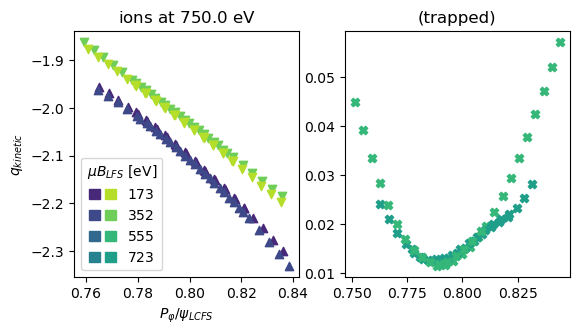

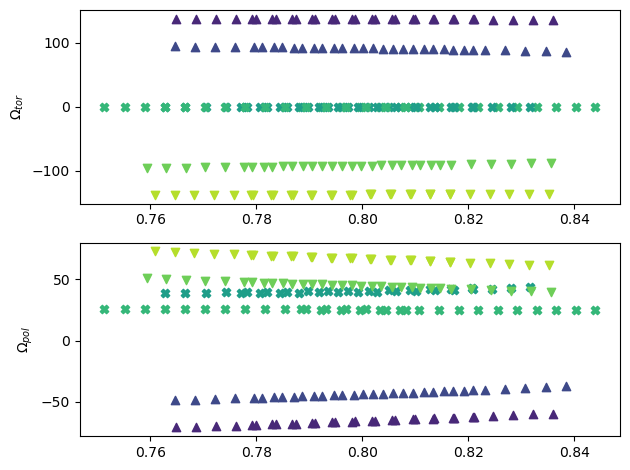

In [23]:

# %% Compute and plot frequencies

k_kev = 0

plt.figure(figsize=(6.4,3.2))
ax = plt.subplot(121)
axt = plt.subplot(122)
#ax = plt.subplot(111)

plt.figure()
ax_tor = plt.subplot(211)
ax_pol = plt.subplot(212)

for k_xi in range(len(xi_grid)):
#for k_xi in [2,-3]:
    for k in range(len(psin_grid)):
        if sol_array[k_kev,k_xi,k] is None:
            continue
        elif len(sol_array[k_kev,k_xi,k].t_events[1]) > 0:
            continue
        else:
            sol = sol_array[k_kev,k_xi,k]
            #rplot, thplot = rz_to_pol(sol.y[0,:], sol.y[2,:])
            #ax.plot(thplot, rplot)
            #ax.plot(sol.y[0,:], sol.y[2,:])
            omega_tor, omega_pol, j_axis = particle_tools.compute_frequencies(sol.t, sol.y[0,:], sol.y[2,:], sol.y[1,:], eq)

            #ham_sol, lphi_sol, mu_sol = particle_motion.compute_integrals_dk(sol, eq, pp, fields, initial=True)
            
            #print(np.median(np.diff(sol.t)))

            #plot_color = mpl.cm.viridis((mu_grid[k_kev,k_xi] - np.min(mu_grid)) / (np.max(mu_grid) - np.min(mu_grid)))
            #plot_color = mpl.cm.viridis(np.abs(xi_grid[k_xi]))
            plot_color = mpl.cm.viridis(xi_grid[k_xi]/2+0.5)
            
            if j_axis == 0:
                plot_marker = 'X' if omega_pol > 0 else 'o'
            else:
                plot_marker = '^' if omega_tor > 0 else 'v'
            
            
            psi_sol = eq.interp_psi.ev(sol.y[0,:], sol.y[2,:])
            psi_avg = scipy.integrate.simpson(psi_sol, x=sol.t) / (sol.t[-1] - sol.t[0])
            
            
            # Split plotting trapped and passing particles
            if j_axis != 0:
                ax.scatter(psi_avg / eq.psix, (omega_tor - omega_frame)/omega_pol, marker=plot_marker, color=plot_color)
            else:
                plot_color = mpl.cm.viridis(np.abs(xi_grid[k_xi])/2+0.5)
                axt.scatter(psi_avg / eq.psix, (omega_tor - omega_frame)/omega_pol, marker=plot_marker, color=plot_color)
            
            
            #ax.scatter(psi_avg / eq.psix, -(omega_tor + omega_adiabat)/omega_pol, marker=plot_marker, color=plot_color)
            ax_tor.scatter(psi_avg / eq.psix, omega_tor, marker=plot_marker, color=plot_color)
            ax_pol.scatter(psi_avg / eq.psix, omega_pol, marker=plot_marker, color=plot_color)

            #ax.scatter(psi_avg / eq.psix, -omega_tor/omega_pol, marker=plot_marker, color=plot_color)
            #axt.scatter(psi_avg / eq.psix, 1/omega_pol, marker=plot_marker, color=plot_color)


#ax.set_xlabel(r'$\langle\psi\rangle / \psi_{LCFS}$')
#axt.set_xlabel(r'$\langle\psi\rangle / \psi_{LCFS}$')
ax.set_xlabel(r'$P_{\varphi} / \psi_{LCFS}$')
#axt.set_xlabel(r'$P_{\varphi} / \psi_{LCFS}$')
ax.set_ylabel(r'$q_{kinetic}$')

ax_tor.set_ylabel(R'$\Omega_{tor}$')
ax_pol.set_ylabel(R'$\Omega_{pol}$')

patches = []
labels = []

for k_xi in range(len(xi_grid)//2):
    plot_color1 = mpl.cm.viridis(xi_grid[k_xi]/2+0.5)
    plot_color2 = mpl.cm.viridis(xi_grid[-1 - k_xi]/2+0.5)
    patches.append((mpl.patches.Patch(color=plot_color1), mpl.patches.Patch(color=plot_color2)))
    labels.append('${:.0f}$'.format(mu_grid[k_kev,k_xi] * modb_outer_ref * 1e3))

#axt.plot(psin_grid, -fields.interp_phi(psin_grid*eq.psix, nu=1) / 40)

ax.set_title('{} at ${}$ eV'.format('electrons' if pp.z < 0 else 'ions', kev_grid[k_kev]*1e3))
ax.legend(patches, labels, handler_map = {tuple: mpl.legend_handler.HandlerTuple(ndivide=None)}, title=r'$\mu B_{LFS}$ [eV]')
axt.set_title('(trapped)')

plt.tight_layout()
plt.show()